# ◆Kickstarter Projects
### 目的：クラウドファンディングが成功するかを名称のみで予測する
### 目的変数をstate（成功 or 失敗）とする二値分類の予測モデルを構築する
- kaggle URL:https://www.kaggle.com/kemical/kickstarter-projects
- Create Date：2020/01/17　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

#### 0.Notebook内で利用する関数の定義

#### 1.データ読込
- 欠損項目を確認する

#### 2.データ前処理
- CountVectorizer（出現する単語のカウントを特徴量にする手法）

#### 3.モデル生成
- SVM Classifier

#### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

#### ※データセット
- 「spam.csv」（データ数：378661, 2）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | state→label |failed or successful | - | ○ |
|  2 | name→text | project name | - | ○ |

## Imports

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections             import Counter
from sklearn.svm             import SVC
from IPython.display         import Markdown, display
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import classification_report, confusion_matrix, accuracy_score
from sklearn                 import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num = 100 # ※1以上の場合有効

# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# 1. Explanatory Data Analysis

In [2]:
df = pd.read_csv("./ks-projects-201801.csv")

df = df.drop(['ID', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 
              'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real'], axis=1)

df = df.rename(columns={"state":"label", "name":"text"})

printmd('▼サイズ')
print(df.shape)

printmd('▼先頭3行')
display(df.head(3))

printmd('▼基本統計量')
display(df.describe())

printmd('▼欠損データ確認')
display(df[df['text'].isnull()])

# 欠損行削除
df.dropna(axis=0,inplace=True)

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))



**▼サイズ**

(378661, 2)




**▼先頭3行**

,text,label
0,The Songs of Adelaide & Abullah,failed
1,Greeting From Earth: ZGAC Arts Capsule For ET,failed
2,Where is Hank?,failed




**▼基本統計量**

,text,label
count,378657,378661
unique,375764,6
top,New EP/Music Development,failed
freq,41,197719




**▼欠損データ確認**

,text,label
166851,NaN,failed
307234,NaN,failed
309991,NaN,suspended
338931,NaN,failed



▼ 欠損データ確認


,Missing num




**▼ 目的変数labelの種類（%）**

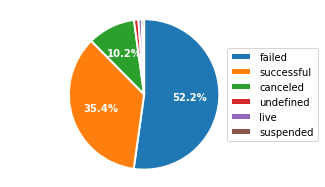



**▼ 件数（successful=1，failed=0）**

text                                        
        count  unique                        top freq
label                                                
0      197716  196761   New EP/Music Development   14
1      133956  133562  A Midsummer Night's Dream    5



**▼ Success rate**

baseline=0.404


In [3]:
printmd('▼ 目的変数labelの種類（%）')
per_class = round(df['label'].value_counts() / len(df['label']) * 100,2)
values = list(per_class.values)

# 円グラフ
plt.figure(figsize=(3,3))
plt.pie(values, labels=list(per_class.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

# stateが成功または失敗のデータを抽出
df = df.query('label in ["successful", "failed"]')

df['label'] = df['label'].map({'failed': 0,'successful': 1})

printmd('▼ 件数（successful=1，failed=0）')
display(df.groupby('label').describe())

printmd('▼ Success rate')
baseline = df['label'].mean()
print('baseline={:.3f}'.format(baseline))


# 2. 前処理
## 2-1. More frequent words in non-spam messages



**▼出現回数が多い単語**

,words in non-spam,count
0,The,31056
1,-,25300
2,the,17276
3,of,16811
4,A,13335


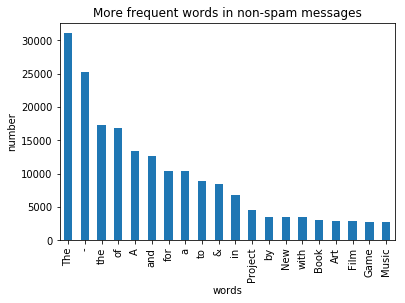

In [4]:
# 失敗

# 出現回数が多い順に要素を取得
count1 = Counter(" ".join(df[df['label']==0]['text']).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

printmd('▼出現回数が多い単語')
display(df1.head(5))

df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

## 2-1. More frequent words in spam messages



**▼出現回数が多い単語**

,words in spam,count_
0,The,24235
1,-,21828
2,the,13141
3,of,12791
4,A,12378


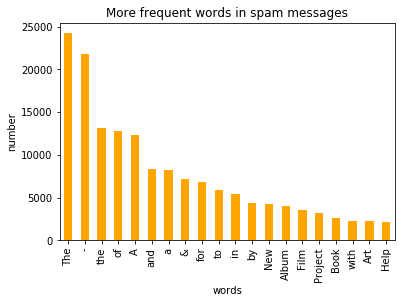

In [5]:
# spam

# 出現回数が多い順に要素を取得
count2 = Counter(" ".join(df[df['label']==1]['text']).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

printmd('▼出現回数が多い単語')
display(df2.head(5))

df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

## 2-2. 特徴量エンジニアリング
- テキストの前処理、トークン化、およびストップワードのフィルタリングは、機能の辞書を構築し、ドキュメントを機能ベクトルに変換できる高レベルのコンポーネントに含まれています。
- sklearnの[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)を使うとBoW(Bag of Words)の特徴量が簡単に作れます
- 分析を改善するためにストップワードを削除します


In [9]:
# 計算時間を考慮してデータ絞込
if squeeze_num > 0:
    df = df[0:squeeze_num]

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.30, random_state=1234)

# テキストドキュメントのコレクションをトークンカウントのマトリックスに変換
f = CountVectorizer(stop_words = 'english')
X_train = f.fit_transform(X_train)
X_test = f.transform(X_test)

print(type(X_train.toarray()))

print('X_train=',X_train[:5,:])

<class 'numpy.ndarray'>
X_train=   (0, 23)	1
  (0, 67)	1
  (0, 132)	1
  (1, 10)	1
  (1, 220)	1
  (1, 96)	1
  (1, 19)	1
  (1, 38)	1
  (1, 77)	1
  (2, 159)	1
  (2, 60)	1
  (2, 49)	1
  (2, 81)	1
  (2, 154)	1
  (2, 192)	1
  (3, 155)	1
  (3, 16)	1
  (3, 57)	1
  (4, 180)	1
  (4, 89)	1
  (4, 4)	1
  (4, 100)	1
  (4, 54)	1
  (4, 167)	1
  (4, 70)	1


## 3.モデル構築（SVM）
- ガウスカーネルでサポートベクターマシンモデルを適用する同じ推論を適用します。
- 正則化パラメーターCを変更してさまざまなモデルをトレーニングします。
- テストセットを使用して、モデルの精度、再現率、および精度を評価します。

In [7]:
list_alpha = [1e-5, 1e-4] 

score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))

count = 0
first_flg = False
for p_alpha in list_alpha:
    
    # モデル生成
    lr = SGDClassifier(loss='log',penalty='l2',alpha= p_alpha, max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
    
    # 学習
    lr.fit(X_train, y_train)
    
    # 結果を格納
    score_train[count] = lr.score(X_train, y_train)
    score_test[count]= lr.score(X_test, y_test)
    
    y_test_pred = lr.predict(X_test)
    recall_test[count] = metrics.recall_score(y_test, y_test_pred)
    precision_test[count] = metrics.precision_score(y_test, y_test_pred)
        
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])
    display(conf_mat)

    count = count + 1 

# 行列に格納
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])

# DataFrameに格納
models = pd.DataFrame(data=matrix, columns=['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])

# テスト結果一覧
display(models.head(n=10))

,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,3,13
正解 = 資金調達成功,1,13


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,11,5
正解 = 資金調達成功,11,3


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,1.0,0.533333,0.928571,0.500
1,0.00010,1.0,0.466667,0.214286,0.375
